Running simulation 1/10


Training loop: 100%|██████████| 300/300 [10:49<00:00,  2.16s/it, acc=98, cost=0.00114]


Running simulation 2/10


Training loop: 100%|██████████| 300/300 [10:33<00:00,  2.11s/it, acc=97.4, cost=0.00214]


Running simulation 3/10


Training loop: 100%|██████████| 300/300 [10:33<00:00,  2.11s/it, acc=97.1, cost=0.00281]


Running simulation 4/10


Training loop: 100%|██████████| 300/300 [10:31<00:00,  2.10s/it, acc=97.3, cost=0.00218]


Running simulation 5/10


Training loop: 100%|██████████| 300/300 [10:29<00:00,  2.10s/it, acc=98, cost=0.00103]


Running simulation 6/10


Training loop: 100%|██████████| 300/300 [10:20<00:00,  2.07s/it, acc=98, cost=0.00103]


Running simulation 7/10


Training loop: 100%|██████████| 300/300 [10:27<00:00,  2.09s/it, acc=97.4, cost=0.00198]


Running simulation 8/10


Training loop: 100%|██████████| 300/300 [10:40<00:00,  2.13s/it, acc=97.5, cost=0.00193]


Running simulation 9/10


Training loop: 100%|██████████| 300/300 [10:42<00:00,  2.14s/it, acc=96.9, cost=0.00251]


Running simulation 10/10


Training loop: 100%|██████████| 300/300 [10:42<00:00,  2.14s/it, acc=98, cost=0.000976]


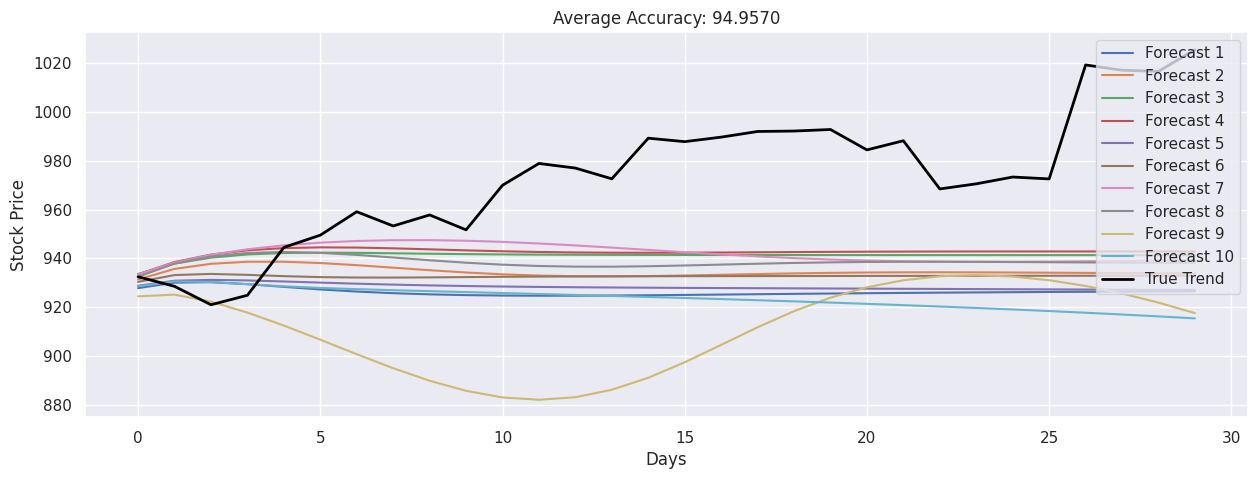

In [ ]:
# ### 1. Importing Libraries and Initial Setup
import sys
import warnings
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

# Suppress warnings for a cleaner output
if not sys.warnoptions:
    warnings.simplefilter('ignore')

# Set styles and random seeds for reproducibility
sns.set()
tf.random.set_seed(1234)

# ### 2. Loading and Preprocessing the Dataset
# Load and preprocess the dataset
df = pd.read_csv('GOOG-year.csv')
minmax = MinMaxScaler().fit(df.iloc[:, 4:5].astype('float32'))
df_log = minmax.transform(df.iloc[:, 4:5].astype('float32'))
df_log = pd.DataFrame(df_log)

# Split data into training and test sets
test_size = 30
simulation_size = 10

df_train = df_log.iloc[:-test_size]
df_test = df_log.iloc[-test_size:]

# ### 3. Setting Hyperparameters
# Set Hyperparameters
size_layer = 128
timestamp = 5
epoch = 300
dropout_rate = 0.8
future_day = test_size
learning_rate = 0.01

# ### 4. Defining the LSTM Model and Helper Functions
# Define the LSTM Model using tf.keras
class Model(tf.keras.Model):
    def __init__(self, size_layer, dropout_rate=0.8):
        super().__init__()
        self.lstm = tf.keras.layers.LSTM(size_layer, return_state=True, return_sequences=True)
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.dense = tf.keras.layers.Dense(df_log.shape[1])

    def call(self, inputs, initial_state=None):
        x, state_h, state_c = self.lstm(inputs, initial_state=initial_state)
        x = self.dropout(x)
        logits = self.dense(x)
        return logits, [state_h, state_c]

# Helper function to calculate accuracy
def calculate_accuracy(real, predict):
    real = np.array(real) + 1
    predict = np.array(predict) + 1
    percentage = 1 - np.sqrt(np.mean(np.square((real - predict) / real)))
    return percentage * 100

# Helper function for smoothing the signal
def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer

# ### 5. Forecasting Function
# Main function to train the model and forecast future values
def forecast():
    model = Model(size_layer, dropout_rate)
    optimizer = tf.keras.optimizers.Adam(learning_rate)

    pbar = tqdm(range(epoch), desc='Training loop')
    for i in pbar:
        initial_state = None
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x = np.expand_dims(df_train.iloc[k:index, :].values, axis=0).astype(np.float32)
            batch_y = np.expand_dims(df_train.iloc[k + 1:index + 1, :].values, axis=0).astype(np.float32)

            with tf.GradientTape() as tape:
                logits, new_state = model(batch_x, initial_state=initial_state)
                loss = tf.reduce_mean(tf.square(batch_y - logits))

            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

            initial_state = new_state
            total_loss.append(loss.numpy())
            accuracy = calculate_accuracy(batch_y[0, :, 0], logits.numpy()[0, :, 0])
            total_acc.append(accuracy)
        pbar.set_postfix(cost=np.mean(total_loss), acc=np.mean(total_acc))

    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]

    initial_state = None
    for k in range(0, df_train.shape[0], timestamp):
        index = min(k + timestamp, df_train.shape[0])
        batch_x = np.expand_dims(df_train.iloc[k:index, :].values, axis=0).astype(np.float32)
        out_logits, new_state = model(batch_x, initial_state=initial_state)
        initial_state = new_state
        output_predict[k + 1 : index + 1] = out_logits[0]

    # Reshape the last known value to be 3D for single-step prediction
    last_val = np.expand_dims(df_train.iloc[-1].values, axis=0)
    last_val = np.expand_dims(last_val, axis=0).astype(np.float32)

    for i in range(future_day):
        out_logits, new_state = model(last_val, initial_state=initial_state)
        initial_state = new_state
        output_predict[df_train.shape[0] + i] = out_logits[0, -1]
        last_val = out_logits

    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.3)

    return deep_future[-test_size:]

# ### 6. Run Simulation and Plot Results
# Run the simulation multiple times
results = []
for i in range(simulation_size):
    print(f'Running simulation {i + 1}/{simulation_size}')
    results.append(forecast())

# Calculate accuracies for each simulation run
accuracies = [calculate_accuracy(df['Close'].iloc[-test_size:].values, r) for r in results]

# Plot the results
plt.figure(figsize=(15, 5))
for no, r in enumerate(results):
    plt.plot(r, label=f'Forecast {no + 1}')

plt.plot(df['Close'].iloc[-test_size:].values, label='True Trend', c='black', linewidth=2)
plt.legend()
plt.title(f'Average Accuracy: {np.mean(accuracies):.4f}')
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.show()

